In [1]:
############## IMPORTING ALL LIBRARIES ######################
import random
import string
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px 
from Preprocess import NepaliPreprocess
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import *
from tensorflow.keras.models import  Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
## LOADING THE PRETRAINED WORD2VEC model : 
model_W2V = Word2Vec.load("w2v/nepaliW2V_5Million.model")



In [3]:
model_W2V.wv.most_similar('राम्रो')

[('राम्ररी', 0.7715420722961426),
 ('पढ्नै', 0.5154498219490051),
 ('बेलै', 0.5036571621894836),
 ('थिइनँ', 0.5017756819725037),
 ('नजान्', 0.49400192499160767),
 ('हुदैन', 0.48048165440559387),
 ('खासै', 0.4774310290813446),
 ('जेनतेन', 0.47497203946113586),
 ('मेहनत', 0.470407634973526),
 ('पछुतो', 0.4699738919734955)]

In [4]:
w2v_weights = model_W2V.wv.vectors
vocab_size, embedding_size = w2v_weights.shape
print(vocab_size, embedding_size)

289961 200


In [5]:
# CONVERT WORD INTO TOKEN
def word2token(word):
    try:
        return model_W2V.wv.key_to_index[word]

    except KeyError:

        return 0
        
# COVERT TOKEN INTO WORD
def token2word(token):
    return model_W2V.wv.index_to_key[token]


In [6]:
data = pd.read_csv("tt6_1649606213.csv")
data.head()



,sentences,label
0,अकर्मण्यताको सिकार भए स्वर्गीय राजा,negative
1,अकुत सम्पत्ति कमाउनेहरूको बिजनेस निकै फस्टाएको...,negative
2,अझ त्यसो गर्दा त्यहाँस्थित अरू देशका राजदूतहरू...,negative
3,अझ नेपालमा त प्रोटोकल मिचेरै कति भेटघाट हुने ग...,negative
4,अझै मरेको छैन,negative


In [7]:
data['Length of sentences'] = data['sentences'].apply(lambda s :len(s.split()))

In [17]:

fig = px.histogram(data, x="Length of sentences")
fig.show()

In [8]:
count_df = data[['label','sentences']].groupby('label').aggregate({'sentences':'count'}).reset_index().sort_values('label',ascending=True)
count_df.head()

,label,sentences
0,negative,1800
1,positive,1800


In [19]:
px.bar(count_df,x='label',y='sentences',
 labels = {"label": "Category of sentences", "sentences": "Total sentences in each class"},
  color = "label", color_continuous_scale = "darkmint")

In [9]:
"""
Applies all the required preprocessing before converting into tokens
It applies : 
1 -> Regex Cleaning to get only the Nepali Words 
2 -> Removes any stopwords if present like अघि अझै किन किनभने
3 -> Performs Stemming
"""
Data_cleaner = NepaliPreprocess()
data["sentences"] = data["sentences"].apply(lambda x: Data_cleaner.Reg_and_Stemming(x))

In [10]:
MAX_SEQUENCE_LENGTH =50
class SequenceIterator:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset
        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.categories, self.ccount = np.unique(dataset.label, return_counts=True)
        self.seq_length = seq_length
        
    def __iter__(self):
        for news, cat in zip(self.dataset.iloc[:, 0], self.dataset.iloc[:, 1]):
            
 
            
            # Clean string of all punctuation
            news = news.translate(self.translator)

            words = np.array([word2token(w) for w in news.split(' ')[:self.seq_length] if w != ''])
                                
            yield (words, cat)

In [11]:
sequences = SequenceIterator(data, seq_length= 40)

In [12]:
cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}
print(cat_dict)

{'negative': 0, 'positive': 1}


In [13]:
############## PADDING THE TOKENS RETURNED FROM THE SequenceIterator Class############
set_x = []
set_y = []
############## CONVERTING THE NP ARRAY TO LIST TO APPLY TOKENIZATION #################
for w, c in sequences:
    set_x.append(w)
    set_y.append(cat_dict[c])
    
# Padding sequences with 0.
set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y = np.array(set_y)


In [14]:

VALID_PER = 0.20 # Percentage of the whole set that will be separated for validation

total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

random_i = random.sample(range(total_samples), total_samples)
train_x = set_x[random_i[:n_train]]
train_y = set_y[random_i[:n_train]]
val_x = set_x[random_i[n_train:n_train+n_val]]
val_y = set_y[random_i[n_train:n_train+n_val]]

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))


categories, ccount = np.unique(train_y, return_counts=True)
n_categories = len(categories)

Train Shapes - X: (2880, 50) - Y: (2880,)
Val Shapes - X: (720, 50) - Y: (720,)


In [23]:
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))




model.add(Bidirectional(LSTM(30)))
model.add(Dropout(0.5))
model.add(Dense(n_categories, activation='sigmoid'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 300)           154755300 
                                                                 
 bidirectional_11 (Bidirecti  (None, 40)               51360     
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 40)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 82        
                                                                 
Total params: 154,806,742
Trainable params: 51,442
Non-trainable params: 154,755,300
_________________________________________________________________


In [24]:
training= model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=4,batch_size=32, verbose=1) 

Epoch 1/4
90/90 [==============================] - 34s 175ms/step - loss: 0.6038 - accuracy: 0.6632 - val_loss: 0.5318 - val_accuracy: 0.7417
Epoch 2/4
90/90 [==============================] - 7s 79ms/step - loss: 0.4801 - accuracy: 0.7757 - val_loss: 0.5046 - val_accuracy: 0.7542
Epoch 3/4
90/90 [==============================] - 7s 77ms/step - loss: 0.4229 - accuracy: 0.8035 - val_loss: 0.4932 - val_accuracy: 0.7569
Epoch 4/4
90/90 [==============================] - 7s 80ms/step - loss: 0.3858 - accuracy: 0.8267 - val_loss: 0.4992 - val_accuracy: 0.7611


In [22]:
model.save('sentiment.h5')

In [59]:
print('Training Accuracy: ', training.history['accuracy'][-1]*100,'%')
print('validation Accuracy: ', training.history['val_accuracy'][-1]*100,'%')
print('Training loss: ', training.history['loss'][-1]*100,'%')
print('validation loss: ', training.history['val_loss'][-1]*100,'%')

Training Accuracy:  98.98343086242676 %
validation Accuracy:  73.3433723449707 %
Training loss:  3.397594392299652 %
validation loss:  112.83336877822876 %


metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True , figsize=(20,5) , dpi = 200)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

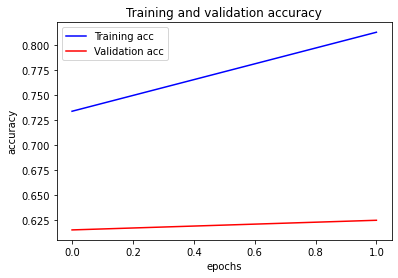

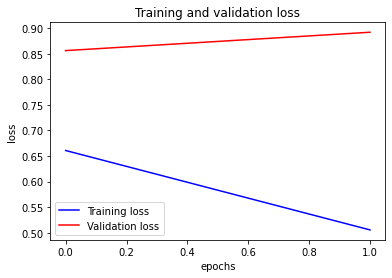

In [164]:
acc,  val_acc  = training.history['accuracy'], training.history['val_accuracy']
loss, val_loss = training.history['loss'], training.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('accuracy.png', dpi=100, bbox_inches='tight')
plt.figure()



plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('loss.png', dpi=100, bbox_inches='tight')
plt.show()





In [117]:
model.save('LSTM9.h5')

################### CONFUSION MATRIX #############
predicted = []
predicted_prob = model.predict(val_x)
for pred in predicted_prob:
    predicted.append(np.argmax(pred))

classes =  np.unique(val_y)
cm = confusion_matrix(val_y, predicted)
fig, ax = plt.subplots(figsize=(5,5) , dpi = 120)
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="\nPredicted values", ylabel="Actual values", xticklabels= classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

In [96]:
from sklearn.metrics import confusion_matrix, classification_report
predicted = []
predicted_prob = model.predict(val_x)
for pred in predicted_prob:
    predicted.append(np.argmax(pred))
cf_matrix = confusion_matrix(val_y,predicted)

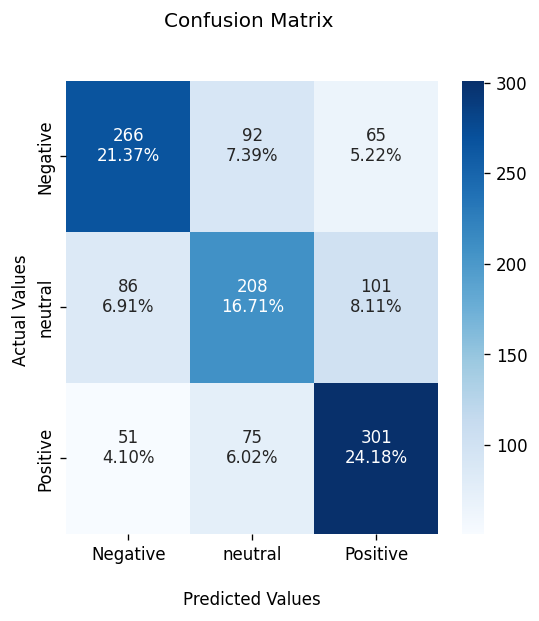

In [120]:
import seaborn as sns
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

fig, ax = plt.subplots(figsize=(5,5) , dpi = 120)
ax = sns.heatmap(cf_matrix, annot=labels, ax=ax, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix \n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
#classes=np.unique(val_y)
classes=['Negative','neutral','Positive']
ax.xaxis.set_ticklabels(classes) 
ax.yaxis.set_ticklabels(classes)

## Display the visualization of the Confusion Matrix.
plt.show()

# classification report for recall, precision and f1 score
print(classification_report(val_y, predicted, labels=[0,1,2], target_names=classes, zero_division=1))
#print(classification_report(val_y, predicted))


In [97]:
print(classification_report(val_y,predicted))


              precision    recall  f1-score   support

           0       0.76      0.75      0.75       373
           1       0.73      0.75      0.74       347

    accuracy                           0.75       720
   macro avg       0.75      0.75      0.75       720
weighted avg       0.75      0.75      0.75       720

